In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
import gatspy
from gatspy.periodic import LombScargle, LombScargleFast

In [3]:
ecl = pd.read_table('ecl.dat',delim_whitespace=True,names=('Object','I','V-I','Depth','P','P_err','t0'))
# ecl

In [58]:
# k = 150
p_cutoff = 0.02
peak_cutoff = 0.1
for k in range(0, 100):
    # this is inside the loop over k
    file = 'phot/I/' + ecl['Object'][k] + '.dat'
    df = pd.read_table(file,delim_whitespace=True,names=('time','mag','err'))
    p = ecl['P'][k]

    phase = np.mod(df['time'], p) / p
    
    n_bin = int(np.floor(len(phase) / 25))
    if n_bin < 20:
        n_bin = 20
    # n_bin = 40
    min_num = 5
    #x_bin = np.zeros(n_bin)
    y_bin = np.zeros(n_bin)
    x_bin = np.linspace(0, 1, n_bin) #+ (0.5 / n_bin)
    mag2 = np.zeros(len(phase))

    for j in range(n_bin):
        data = np.where((phase >= j/n_bin) & (phase < (j + 1)/n_bin))[0]
        # if theres not enough data, dont fill the bin
        if len(data) >= min_num:
            # x_bin[j] = np.median(phase[data])
            y_bin[j] = np.median(df['mag'].values[data])
            mag2[data] = df['mag'].values[data] - y_bin[j]
    
    ls = LombScargleFast(fit_period=True)
    ls.optimizer.period_range = (0.1, 20)
    ls.optimizer.quiet=True
    ls.fit(df['time'], mag2, df['err'])
    peak = ls.find_best_periods(n_periods=1, return_scores=True);
    # print(peak, p2)
    p2 = peak[0]
    new_p = np.abs((p2 - p)/p) > p_cutoff    
    if new_p:
        if peak[1] > peak_cutoff:
            if (p2 > 0.99) & (p2 < 1.01):
                print('WARNING, 1 DAY!')

            phase2 = np.mod(df['time'], p2) / p2

            plt.figure()
            plt.scatter(phase2, mag2, alpha = 0.5, c = df['time'])
            plt.xlabel('phase (p2 =' + str(p2) + ', p = ' + str(p) + ')')
            plt.ylabel('I [mag]')
            plt.title(ecl['Object'][k])
            plt.xlim(0, 1)
            plt.gca().invert_yaxis()
            plt.savefig('figures/' + ecl['Object'][k] + '_p2.png')
            plt.close()
            
            plt.figure()
            plt.scatter(phase, df['mag'], alpha = 0.5, c = df['time'])
            plt.xlabel('phase (P =' + str(p) + ')')
            plt.ylabel('I [mag]')
            plt.title(ecl['Object'][k])
            plt.xlim(0, 1)
            plt.plot(x_bin, y_bin, c = 'yellow', lw = 3, alpha = .5)
            plt.scatter(phase, mag2 + np.max(df['mag']) + 0.2, s = 2, c = 'black')
            plt.gca().invert_yaxis()
            plt.savefig('figures/' + ecl['Object'][k] + '_p1.png')
            plt.close()

WARNING, 1 DAY!
WARNING, 1 DAY!
WARNING, 1 DAY!
WARNING, 1 DAY!
WARNING, 1 DAY!
WARNING, 1 DAY!


In [ ]:
# Step 3: Subtract off known period. Using polyfit or a running median, etc.
# Step 4: Make a new periodogram and search for new periods.

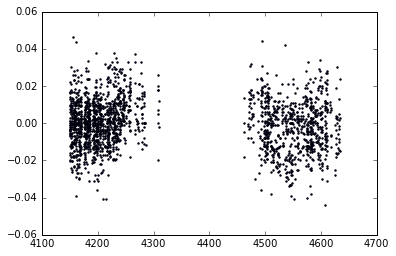

In [5]:
#plt.scatter(df['time'], df['mag'])
plt.scatter(df['time'], mag2, s = 2)

In [21]:
# Make Lomb-Scargle periodogram on mag2 using gatspy
# http://www.astroml.org/gatspy/periodic/API.html#gatspy.periodic.LombScargle

/astro/users/ja995/.local/lib/python3.5/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


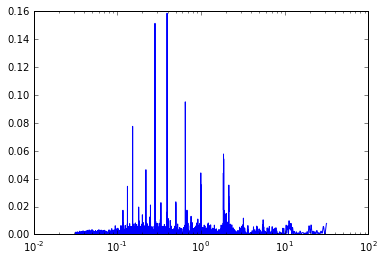

In [32]:
ls = LombScargleFast().fit(df['time'], mag2, df['err'])
periods = np.logspace(-1.5, 1.5, 5000)
power = ls.periodogram(periods=periods)
plt.plot(periods, power)
plt.xscale('log')

In [35]:
ls.optimizer.period_range = (0.1, 20)
p2 = ls.best_period
p_cutoff = 0.05
print(np.abs((p2 - p)/p) > p_cutoff)

Finding optimal frequency:
 - Estimated peak width = 0.013
 - Using 5 steps per peak; omega_step = 0.0026
 - User-specified period range:  0.1 to 20
 - Computing periods at 24072 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
False


In [50]:
ls.optimizer.quiet=True
ls.find_best_periods(n_periods=1, return_scores=True)

(array([ 10.2190298]), array([ 0.00896931]))

In [55]:
len(ecl) * .03

347.37

# NOTES 

- Run for all objects
- Save plots to files
- Save original phase folded plot
- Save big table of new periods, amplitudes, warnings
